In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import rho_plus as rp

theme, cs = rp.mpl_setup(False)

plt.rcParams['legend.labelcolor'] = plt.rcParams['axes.titlecolor']
plt.rcParams['legend.edgecolor'] = plt.rcParams['axes.facecolor']
plt.rcParams['font.family'] = 'Source Han Sans JP'

In [ ]:
data = pd.read_feather('mpc_full_feats_scaled_split.feather')
data

,comp,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,minimum Number,maximum Number,range Number,...,infoY_delta_e,statY_bandgap,infoY_bandgap,Rsplt1,Rsplt2,Rsplt3,Rsplt4,Rsplt5,piezo,dataset_split
0,In1,-2.544139,4.304959,4.099305,3.846319,3.738150,3.663704,2.864847,0.010989,-1.760193,...,False,False,False,False,False,False,False,False,False,1
1,Mg1,-2.544139,4.304959,4.099305,3.846319,3.738150,3.663704,-0.041846,-1.664706,-1.760193,...,False,False,False,False,True,False,False,True,False,0
2,Be1,-2.544139,4.304959,4.099305,3.846319,3.738150,3.663704,-0.670320,-2.027018,-1.760193,...,False,False,False,False,False,False,False,False,False,2
3,Hf1,-2.544139,4.304959,4.099305,3.846319,3.738150,3.663704,4.671710,1.052637,-1.760193,...,False,False,False,False,False,False,False,False,False,1
4,P1,-2.544139,4.304959,4.099305,3.846319,3.738150,3.663704,0.193832,-1.528839,-1.760193,...,False,False,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84185,Sb2W1O6,-0.302404,0.587564,0.680144,0.747711,0.764994,0.771629,-0.356083,1.143215,1.446811,...,False,False,False,False,False,False,False,False,True,0
84186,Sr1Hf1O3,-0.302404,-0.032556,0.033257,0.130844,0.170592,0.193219,-0.356083,1.052637,1.349629,...,False,False,False,False,False,False,False,False,True,1
84187,Rb1Ta1O3,-0.302404,-0.032556,0.033257,0.130844,0.170592,0.193219,-0.356083,1.097926,1.398220,...,False,False,False,False,False,False,False,False,True,1
84188,Ba1Ni1O3,-0.302404,-0.032556,0.033257,0.130844,0.170592,0.193219,-0.356083,0.328012,0.572174,...,False,False,False,False,False,False,False,False,True,0


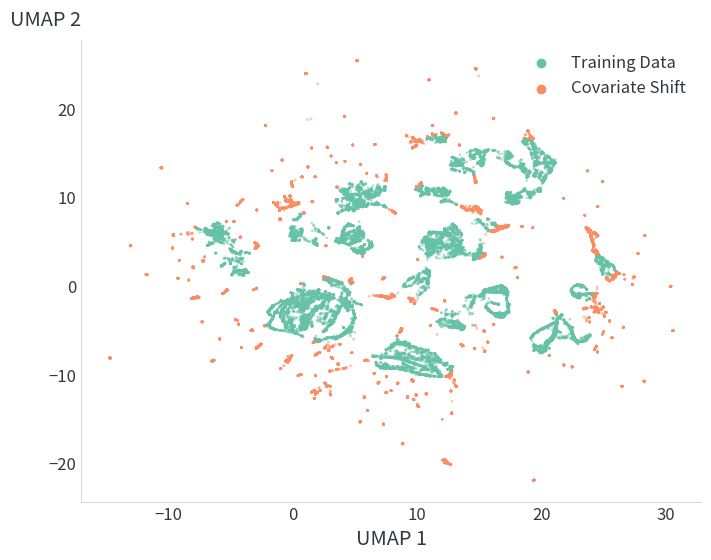

In [3]:
data['Dataset'] = ['Covariate Shift' if x else 'Training Data' for x in data['Xshift_umap']]
test_sets = data.select_dtypes(bool)
data['num_test_sets'] = data[test_sets].sum(axis=1)
data['training'] = data['num_test_sets'] == 0
ax = sns.scatterplot(data.query('training or Xshift_umap'), x='umap_x', y='umap_y', hue='Dataset', ec=None, s=3,
                     legend=False, alpha=0.5, palette='Set2', hue_order=['Training Data', 'Covariate Shift'])

c1, c2 = sns.color_palette('Set2', 2)
plt.scatter([], [], color=c1, label='Training Data')
plt.scatter([], [], color=c2, label='Covariate Shift')
plt.legend()
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
rp.ylabel_top()
plt.savefig('figs/umap_dist.png')

/tmp/ipykernel_1028840/1700105556.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ydata['Dataset'] = np.where(ydata['infoY_delta_e'], 'Prior Shift', 'Training')


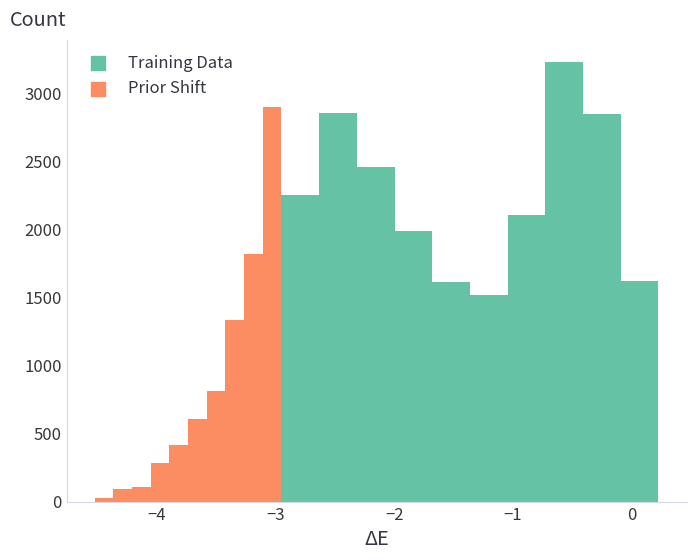

In [4]:
ydata = data.query('training or infoY_delta_e')
ydata['Dataset'] = np.where(ydata['infoY_delta_e'], 'Prior Shift', 'Training')

bins = np.hstack([
    np.histogram_bin_edges(ydata.query('infoY_delta_e')['delta_e']),
    np.histogram_bin_edges(ydata.query('training')['delta_e'])
])
alpha = 1
sns.histplot(ydata, x='delta_e', hue='Dataset', bins=bins, palette='Set2', alpha=alpha, ec='black')
plt.scatter([], [], color=c1, label='Training Data', marker='s', s=100, alpha=alpha)
plt.scatter([], [], color=c2, label='Prior Shift', marker='s', s=100, alpha=alpha)
plt.legend()
plt.xlabel('ΔE')
rp.ylabel_top()
plt.savefig('figs/prior_dist.png')

In [5]:
from umap import UMAP
from umap.umap_ import nearest_neighbors

# sup_data = data.query('dataset_split >= 0')
# umap_Xy = sup_data.select_dtypes('number').drop(columns=['TSNE_x', 'TSNE_y', 'bandgap', 'magmom_pa', 'dataset_split'])
# umap_X = umap_Xy.drop(columns=['delta_e'])
# umap_y = umap_Xy['delta_e']

# knn = nearest_neighbors(
#     umap_X,
#     n_neighbors=250,
#     metric="manhattan",
#     metric_kwds=None,
#     angular=False,
#     random_state=2718,
# )

# umap = UMAP(n_neighbors=200, precomputed_knn=knn, min_dist=0.7)

# sup_data[['sup_umap_x', 'sup_umap_y']] = umap.fit_transform(umap_X, y=umap_y)

sup_data = pd.read_feather('umap_data.feather')

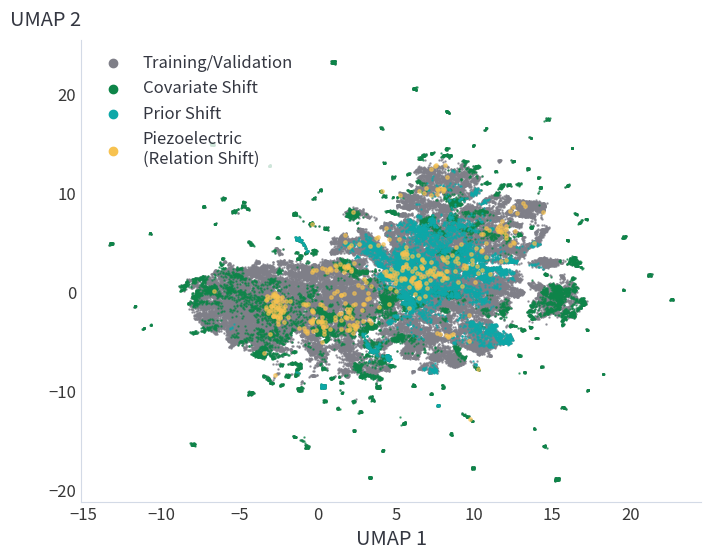

In [6]:
splits = {
    'Training/Validation': sup_data.query('training or Rsplt1 or Rsplt2 or Rsplt3 or Rsplt4 or Rsplt5'),
    'Covariate Shift': sup_data.query('Xshift_umap'),
    'Prior Shift': sup_data.query('infoY_delta_e'),
    'Piezoelectric\n(Relation Shift)': sup_data.query('piezo'),
}

split_kwargs = {
    'Training/Validation': {'alpha': 0.8},
    'Piezoelectric\n(Relation Shift)': {'s': 6, 'alpha': 0.6},
}

colors = ['#c5c5c5', *sns.color_palette('Accent', n_colors=len(splits))]

# FADCE9
# AED0EA
# 2E317C 
# ADD5A2
# 5DBE8A
# F7E8AA

colors = ['#7f7f88', 
          '#0e8549',          
          '#0da8a8',
          '#f7c250',
          ]

for (name, split), color in zip(splits.items(), colors):
    kwargs = {'s': 0.5, 'color': color, 'alpha': 0.7}
    kwargs.update(split_kwargs.get(name, {}))
    plt.scatter(split['sup_umap_x'], split['sup_umap_y'], **kwargs)
    plt.scatter([], [], color=color, label=name)

plt.legend()
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
rp.ylabel_top()
plt.savefig('figs/global_umap.png')

In [7]:
df = pd.read_csv('ablation.csv')
df = df.melt(id_vars=['type', 'epoch'], var_name='dataset', value_name='loss')

df['sal'] = df['type'].str.contains('Y info') | df['type'].str.contains('SAL')
df['type'] = df['type'].str.removeprefix('SAL ')
df['last'] = df['epoch'] == 'last'
df['ema'] = df['epoch'] == 'EMA'
fig_sets = {
    'train': 'Training',
    'piezo': "Piezoelectric\n(Relation Shift)",
    # 'Xshift_tsne': "X shift (TSNE)",
    'Xshift_umap': "Covariate Shift",
    # 'statY_delta_e': "Extreme ΔE\n(Prior Shift)",
    'infoY_delta_e': "Low ΔE\n(Prior Shift)",
    'statY_bandgap': "High-Bandgap\nMaterials",
    'rsplt_ave': 'Validation'
}
df['fig'] = df['dataset'].isin(fig_sets)
df['dataset'] = [fig_sets.get(x, x) for x in df['dataset']]
df['dataset_size'] = df['type'].str.extract(r'(\d+)x(\d+)').applymap(float).prod(axis=1)
df['type'] = df['type'].str.rstrip('1234567890x').str.removesuffix(' ')
df

/tmp/ipykernel_1028840/1477999188.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df['dataset_size'] = df['type'].str.extract(r'(\d+)x(\d+)').applymap(float).prod(axis=1)


,type,epoch,dataset,loss,sal,last,ema,fig,dataset_size
0,Y info,354,Training,0.1010,True,False,False,True,256.0
1,Y info,355,Training,0.1080,True,False,False,True,256.0
2,Y info,356,Training,0.0870,True,False,False,True,256.0
3,Y info,last,Training,0.0894,True,True,False,True,256.0
4,Y info,EMA,Training,0.0383,True,False,True,True,256.0
...,...,...,...,...,...,...,...,...,...
1570,Xumap,EMA,Validation,0.0893,True,False,True,True,1.0
1571,statY,196,Validation,0.1288,True,False,False,True,1024.0
1572,statY,last,Validation,0.1248,True,True,False,True,1024.0
1573,statY,EMA,Validation,0.2007,True,False,True,True,1024.0


['Covariate Shift', 'High-Bandgap\nMaterials', 'Low ΔE\n(Prior Shift)', 'Piezoelectric\n(Relation Shift)', 'Training', 'Validation']


/tmp/ipykernel_1028840/1831943224.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subs['theta'] = [col_x[c] for c in subs['dataset']]


,type,epoch,dataset,loss,sal,last,ema,fig,dataset_size,theta
944,baseline,EMA,Covariate Shift,0.0841,False,False,True,True,1.0,0.000000
1259,baseline,EMA,High-Bandgap\nMaterials,0.1400,False,False,True,True,1.0,1.047198
1154,baseline,EMA,Low ΔE\n(Prior Shift),0.1602,False,False,True,True,1.0,2.094395
1469,baseline,EMA,Piezoelectric\n(Relation Shift),0.0840,False,False,True,True,1.0,3.141593
104,baseline,EMA,Training,0.0011,False,False,True,True,1.0,4.188790
1574,baseline,EMA,Validation,0.0830,False,False,True,True,1.0,5.235988
944,baseline,EMA,Covariate Shift,0.0841,False,False,True,True,1.0,6.283185


,type,epoch,dataset,loss,sal,last,ema,fig,dataset_size,theta
934,baseline,EMA,Covariate Shift,0.0856,True,False,True,True,1.0,0.000000
1249,baseline,EMA,High-Bandgap\nMaterials,0.1388,True,False,True,True,1.0,1.047198
1144,baseline,EMA,Low ΔE\n(Prior Shift),0.1564,True,False,True,True,1.0,2.094395
1459,baseline,EMA,Piezoelectric\n(Relation Shift),0.0781,True,False,True,True,1.0,3.141593
94,baseline,EMA,Training,0.0061,True,False,True,True,1.0,4.188790
1564,baseline,EMA,Validation,0.0851,True,False,True,True,1.0,5.235988
934,baseline,EMA,Covariate Shift,0.0856,True,False,True,True,1.0,6.283185


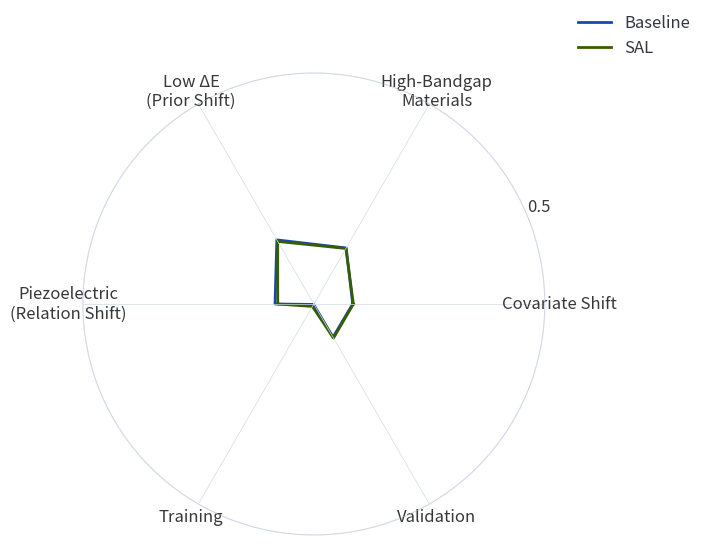

In [8]:
def radial_plot(subs):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

    cols = sorted(pd.unique(subs['dataset']))
    print(cols)
    n_cols = len(cols)
    col_x = {ds: i * 2 * np.pi / n_cols for i, ds in enumerate(cols)}
    subs['theta'] = [col_x[c] for c in subs['dataset']]

    for sal_val, color, label in zip((False, True), cs, ('Baseline', 'SAL')):
        group = subs.query('sal == @sal_val').sort_values('theta')
        last_row = group.iloc[[0]].copy()
        last_row['theta'] += 2 * np.pi
        group = pd.concat([group, last_row], axis=0)
        display(group)
        ax.plot(group['theta'], group['loss'], label=label, color=color, zorder=2, lw=2)

    fig.legend()
    ticks = list(col_x.values())
    ticklabels = list(col_x.keys())
    ax.set_xticks(ticks=ticks, labels=ticklabels)
    ax.set_thetamax(360)
    return fig, ax

subs = df.query('type == "baseline" and ema and fig')
fig, ax = radial_plot(subs)
ax.set_rticks([0.5])
ax.grid(lw=0.5)
fig.savefig('figs/radial_baseline.png')

/tmp/ipykernel_1028840/3197789015.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subs['CAL'] = np.where(subs['sal'], 'CAL', 'Baseline')


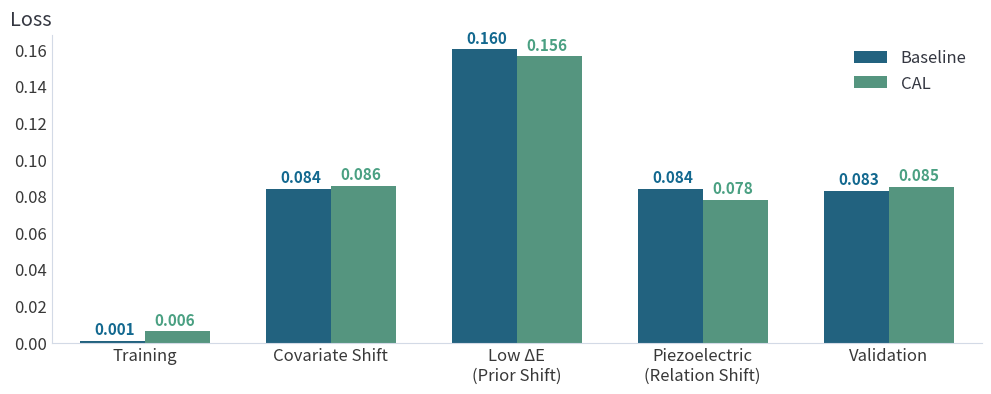

In [97]:
def normal_plot(subs):
    fig, ax = plt.subplots(figsize=(12, 4))
    subs['CAL'] = np.where(subs['sal'], 'CAL', 'Baseline')
    colors = sns.color_palette('rho_viridia', 2)    

    sns.barplot(subs, hue='CAL', x='dataset', y='loss', ax=ax, hue_order=['Baseline', 'CAL'], width=0.7,
                palette=colors)
    
    x_offset = 0.16         

    ymin, ymax = ax.get_ylim()
    y_offset = 0.02 * (ymax - ymin)
    
    for ds_i, ds in enumerate(pd.unique(subs['dataset'])):
        for method_i, method in enumerate(('Baseline', 'CAL')):
            rect: Rectangle = ax.patches[2 * ds_i + method_i]       
            loss = subs[(subs['dataset'] == ds) & (subs['sal'] == bool(method_i))]['loss'].iloc[0]             
            ax.text(x=ds_i + x_offset * (2 * method_i - 1), y=loss + y_offset, s=f'{loss:.03f}', ha='center',
                    color=colors[method_i], fontweight='bold', fontsize=11)     
    
    ax.set_xlabel('')
    ax.get_legend().set_title('')
    ax.get_legend().set_frame_on(False)
    ax.set_ylabel('Loss')
    rp.ylabel_top(ax)
    return fig, ax

fig, ax = normal_plot(subs[subs['dataset'] != "High-Bandgap\nMaterials"])

from matplotlib.patches import Rectangle
from matplotlib.axes import Axes

fig.savefig('figs/normal_baseline.png')

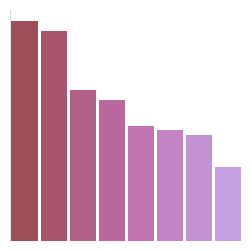

In [10]:
rng = np.random.default_rng(124)

xs = np.sort(rng.gamma(2, 1, size=8))[::-1] ** 0.4

pal = sns.cubehelix_palette(n_colors=len(xs), start=1.7, rot=-0.7, gamma=1, hue=1, light=0.7, dark=0.4)

fig, ax = plt.subplots(figsize=(3, 3))
sns.barplot(y=xs, x=np.arange(len(xs)), palette=pal, orient='v', width=0.9, hue=xs, legend=False, saturation=1)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
sns.despine(bottom=True)

plt.savefig('figs/err_fig.png')

In [20]:
df['CAL'] = np.where(df['sal'], 'CAL', 'Baseline')

dataset_target = df['type'].copy()
dataset_target.iloc[:] = ""
dataset_target.loc[(df['type'] == 'finetune') & (df['dataset_size'] == 1024)] = 'Low ΔE\n(Prior Shift)'
dataset_target.loc[(df['type'] == 'Y info') & (df['dataset_size'] == 1024)] = 'Low ΔE\n(Prior Shift)'
dataset_target.loc[(df['type'] == "Piezo2") & (df['dataset_size'] == 256)] = 'Piezoelectric\n(Relation Shift)'
dataset_target.loc[(df['type'] == "Finetune Piezo") & (df['dataset_size'] == 256)] = 'Piezoelectric\n(Relation Shift)'
dataset_target.loc[df['type'] == "Xumap"] = 'Covariate Shift'


df['target'] = dataset_target

targeted = df[df['target'] == df['dataset']].query('ema')
targeted

,type,epoch,dataset,loss,sal,last,ema,fig,dataset_size,CAL,target,post
928,Xumap,EMA,Covariate Shift,0.073838,False,False,True,True,1.0,Baseline,Covariate Shift,False
940,Xumap,EMA,Covariate Shift,0.064700,True,False,True,True,1.0,CAL,Covariate Shift,False
1064,Y info,EMA,Low ΔE\n(Prior Shift),0.019200,True,False,True,True,1024.0,CAL,Low ΔE\n(Prior Shift),True
1088,finetune,EMA,Low ΔE\n(Prior Shift),0.015400,False,False,True,True,1024.0,Baseline,Low ΔE\n(Prior Shift),True
1420,Finetune Piezo,EMA,Piezoelectric\n(Relation Shift),0.117600,False,False,True,True,256.0,Baseline,Piezoelectric\n(Relation Shift),False
1462,Piezo2,EMA,Piezoelectric\n(Relation Shift),0.033600,True,False,True,True,256.0,CAL,Piezoelectric\n(Relation Shift),False


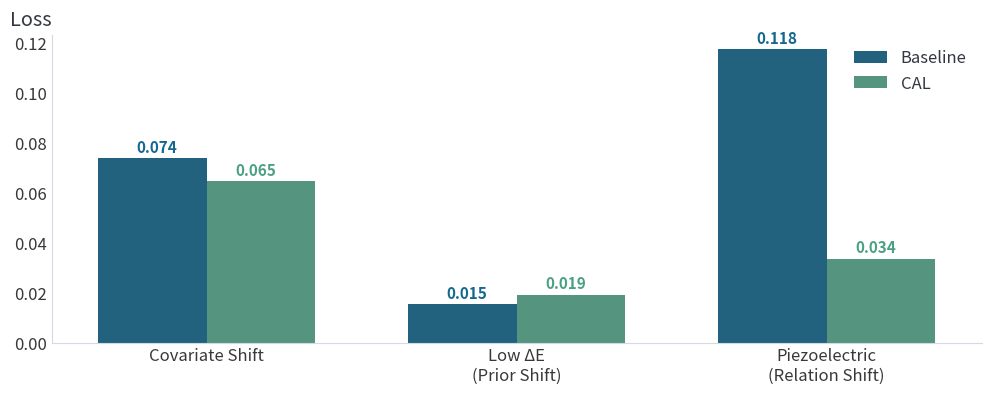

In [100]:
# fig, ax = plt.subplots(figsize=(9, 4))
# ax = sns.barplot(targeted, x='dataset', y='loss', hue='CAL',
#                  hue_order=('Baseline', 'CAL'), palette='rho_viridia')

# ax.get_legend().set_title('')
# ax.set_xlabel('')
# ax.set_ylabel('Loss')
# rp.ylabel_top()

fig, ax = normal_plot(targeted)

fig.savefig('figs/targeted.png')

In [13]:
df['post'] = df['type'].isin(('Y info', 'finetune'))
post = df.query('post')
post

,type,epoch,dataset,loss,sal,last,ema,fig,dataset_size,CAL,target,post
0,Y info,354,Training,0.1010,True,False,False,True,256.0,CAL,,True
1,Y info,355,Training,0.1080,True,False,False,True,256.0,CAL,,True
2,Y info,356,Training,0.0870,True,False,False,True,256.0,CAL,,True
3,Y info,last,Training,0.0894,True,True,False,True,256.0,CAL,,True
4,Y info,EMA,Training,0.0383,True,False,True,True,256.0,CAL,,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1509,finetune,best_vaild_0.0055_66,Validation,0.0776,False,False,False,True,1024.0,Baseline,Low ΔE\n(Prior Shift),True
1510,finetune,IR3_best_train_0.0003_100,Validation,0.0764,False,False,False,True,1024.0,Baseline,Low ΔE\n(Prior Shift),True
1511,finetune,last,Validation,0.0759,False,True,False,True,1024.0,Baseline,Low ΔE\n(Prior Shift),True
1512,finetune,best_vaild_0.0055_77,Validation,0.0774,False,False,False,True,1024.0,Baseline,Low ΔE\n(Prior Shift),True


In [14]:
# sns.lineplot(post.query('fig and ema and dataset == "Low ΔE"'), hue='sal', x='dataset_size', y='loss')
# sns.lineplot(post.query('fig and last and dataset == "Low ΔE"'), hue='sal', x='dataset_size', y='loss')

,type,epoch,dataset,loss,sal,last,ema,fig,dataset_size,CAL,target,post
13,Y info,last,Training,0.0774,True,True,False,True,1024.0,CAL,Low ΔE\n(Prior Shift),True
41,finetune,last,Training,0.0006,False,True,False,True,1024.0,Baseline,Low ΔE\n(Prior Shift),True
853,Y info,last,Covariate Shift,0.1827,True,True,False,True,1024.0,CAL,Low ΔE\n(Prior Shift),True
881,finetune,last,Covariate Shift,0.0917,False,True,False,True,1024.0,Baseline,Low ΔE\n(Prior Shift),True
1063,Y info,last,Low ΔE\n(Prior Shift),0.0268,True,True,False,True,1024.0,CAL,Low ΔE\n(Prior Shift),True
1091,finetune,last,Low ΔE\n(Prior Shift),0.0059,False,True,False,True,1024.0,Baseline,Low ΔE\n(Prior Shift),True
1168,Y info,last,High-Bandgap\nMaterials,0.0422,True,True,False,True,1024.0,CAL,Low ΔE\n(Prior Shift),True
1196,finetune,last,High-Bandgap\nMaterials,0.0234,False,True,False,True,1024.0,Baseline,Low ΔE\n(Prior Shift),True
1378,Y info,last,Piezoelectric\n(Relation Shift),0.1186,True,True,False,True,1024.0,CAL,Low ΔE\n(Prior Shift),True
1406,finetune,last,Piezoelectric\n(Relation Shift),0.0878,False,True,False,True,1024.0,Baseline,Low ΔE\n(Prior Shift),True


['Covariate Shift', 'High-Bandgap\nMaterials', 'Low ΔE\n(Prior Shift)', 'Piezoelectric\n(Relation Shift)', 'Training', 'Validation']


,type,epoch,dataset,loss,sal,last,ema,fig,dataset_size,CAL,target,post,theta
881,finetune,last,Covariate Shift,0.0917,False,True,False,True,1024.0,Baseline,Low ΔE\n(Prior Shift),True,0.000000
1196,finetune,last,High-Bandgap\nMaterials,0.0234,False,True,False,True,1024.0,Baseline,Low ΔE\n(Prior Shift),True,1.047198
1091,finetune,last,Low ΔE\n(Prior Shift),0.0059,False,True,False,True,1024.0,Baseline,Low ΔE\n(Prior Shift),True,2.094395
1406,finetune,last,Piezoelectric\n(Relation Shift),0.0878,False,True,False,True,1024.0,Baseline,Low ΔE\n(Prior Shift),True,3.141593
41,finetune,last,Training,0.0006,False,True,False,True,1024.0,Baseline,Low ΔE\n(Prior Shift),True,4.188790
1511,finetune,last,Validation,0.0759,False,True,False,True,1024.0,Baseline,Low ΔE\n(Prior Shift),True,5.235988
881,finetune,last,Covariate Shift,0.0917,False,True,False,True,1024.0,Baseline,Low ΔE\n(Prior Shift),True,6.283185


,type,epoch,dataset,loss,sal,last,ema,fig,dataset_size,CAL,target,post,theta
853,Y info,last,Covariate Shift,0.1827,True,True,False,True,1024.0,CAL,Low ΔE\n(Prior Shift),True,0.000000
1168,Y info,last,High-Bandgap\nMaterials,0.0422,True,True,False,True,1024.0,CAL,Low ΔE\n(Prior Shift),True,1.047198
1063,Y info,last,Low ΔE\n(Prior Shift),0.0268,True,True,False,True,1024.0,CAL,Low ΔE\n(Prior Shift),True,2.094395
1378,Y info,last,Piezoelectric\n(Relation Shift),0.1186,True,True,False,True,1024.0,CAL,Low ΔE\n(Prior Shift),True,3.141593
13,Y info,last,Training,0.0774,True,True,False,True,1024.0,CAL,Low ΔE\n(Prior Shift),True,4.188790
1483,Y info,last,Validation,0.1436,True,True,False,True,1024.0,CAL,Low ΔE\n(Prior Shift),True,5.235988
853,Y info,last,Covariate Shift,0.1827,True,True,False,True,1024.0,CAL,Low ΔE\n(Prior Shift),True,6.283185


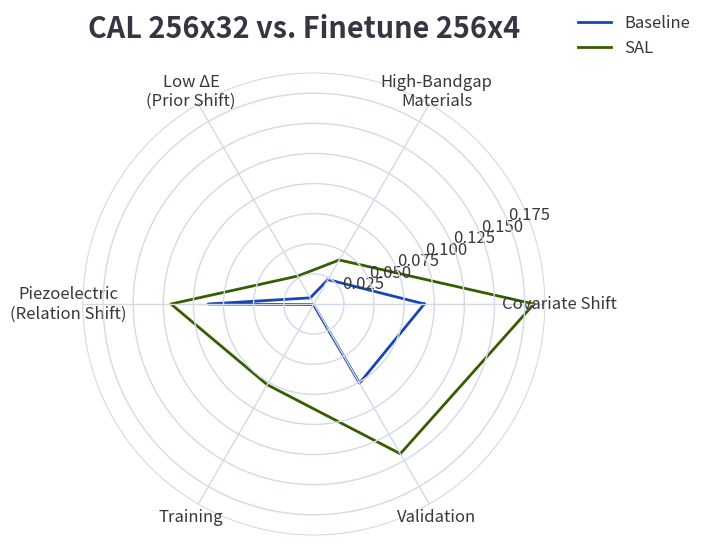

In [15]:
last_best = post.query('fig and last')
last_best = last_best.query('(type == "finetune" and dataset_size == 1024) or (type == "Y info" and dataset_size == 1024)')
display(last_best)
fig, ax = radial_plot(last_best)
fig.suptitle('CAL 256x32 vs. Finetune 256x4')
fig.savefig('figs/radial_infoy_last.png')

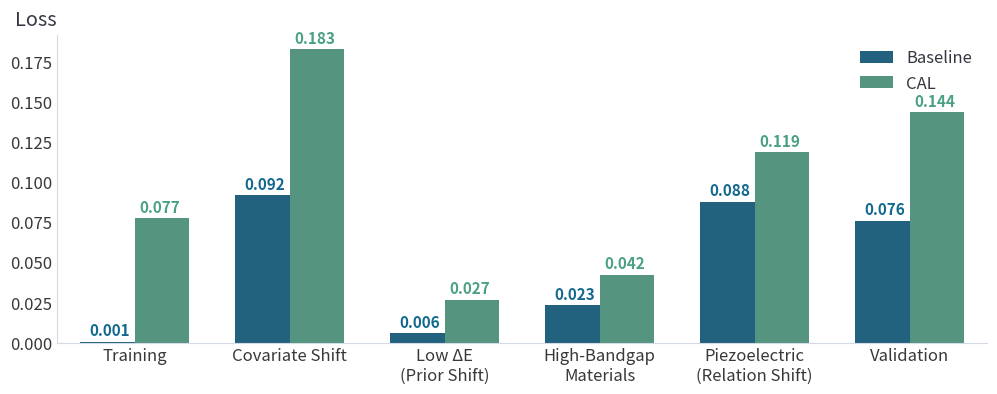

In [101]:
fig, ax = normal_plot(last_best)
# fig.suptitle('SAL 256x32 vs. Finetune 256x4')
fig.savefig('figs/normal_infoy_last.png')

In [17]:
pd.read_feather('exps/delta_e_piezo_2/SAL-training_loss.feather')

,epoch,Train,Partial_train,Rsplt1,Rsplt2,Rsplt3,Rsplt4,Rsplt5,Xshift_tsne,Xshift_umap,statY_delta_e,infoY_delta_e,statY_bandgap,infoY_bandgap,piezo,rsplt_ave,Partial
0,1,0.034715,0.164271,0.102765,0.102031,0.106452,0.108030,0.106872,0.092764,0.123653,0.691778,0.140333,0.156589,0.113302,0.076228,0.105230,NaN
1,2,0.028391,0.050317,0.097718,0.097023,0.101424,0.103113,0.101577,0.088762,0.118496,0.687930,0.135183,0.146572,0.104617,0.069712,0.100171,NaN
2,3,0.026510,0.038649,0.095945,0.095165,0.099448,0.101209,0.099720,0.086470,0.115253,0.684378,0.135769,0.147040,0.104634,0.066970,0.098297,NaN
3,4,0.025408,0.034084,0.094484,0.093560,0.097961,0.099736,0.098228,0.083687,0.112614,0.681039,0.129008,0.138776,0.098714,0.063788,0.096794,NaN
4,5,0.058007,0.194969,0.140352,0.137347,0.145336,0.145452,0.144588,0.166109,0.167949,0.685957,0.264363,0.447714,0.317613,0.039905,0.142615,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,215,0.031007,0.052083,0.109190,0.106569,0.112818,0.114197,0.114178,0.115088,0.136282,0.675602,0.219320,0.305395,0.216091,0.036289,0.111390,NaN
215,216,0.039033,0.048609,0.113077,0.111300,0.117011,0.117136,0.118751,0.122645,0.141093,0.637092,0.235291,0.325209,0.232565,0.037022,0.115455,NaN
216,217,0.025309,0.143991,0.105122,0.103003,0.108424,0.110145,0.109189,0.099944,0.123529,0.702161,0.184028,0.213299,0.157823,0.033452,0.107177,NaN
217,218,0.045642,0.063121,0.130908,0.128928,0.133781,0.137211,0.135112,0.121632,0.170137,0.791748,0.154929,0.150374,0.118313,0.033975,0.133188,NaN


In [18]:
pd.concat([piezo_fig, pd.DataFrame({'type': ['Piezo2'], 'epoch': ['EMA'], 'dataset': ['Piezoelectric\n(Relation Shift)'], 'loss': [0.0548], 'sal': [True], 'last': [False], 'ema': [True], 'fig': [True], 'dataset_size': [128], 'CAL': ['CAL'], 'target': [''], 'post': [False], 'Training Data Size': [128]})])

NameError: name 'piezo_fig' is not defined

In [ ]:
piezo_fig

,type,epoch,dataset,loss,sal,last,ema,fig,dataset_size,CAL,target,post,Training Data Size
1403,Finetune Piezo,EMA,Piezoelectric\n(Relation Shift),0.1042,False,False,True,True,128.0,Baseline,,False,128
1407,Finetune Piezo,EMA,Piezoelectric\n(Relation Shift),0.1176,False,False,True,True,256.0,Baseline,Piezoelectric\n(Relation Shift),False,256
1429,Piezo2 old,EMA,Piezoelectric\n(Relation Shift),0.0365,True,False,True,True,256.0,CAL,,False,256
1433,Piezo2 old,EMA,Piezoelectric\n(Relation Shift),0.0542,True,False,True,True,128.0,CAL,,False,128
1449,Piezo2,EMA,Piezoelectric\n(Relation Shift),0.0336,True,False,True,True,256.0,CAL,Piezoelectric\n(Relation Shift),False,256
9999,Piezo2,EMA,Piezoelectric\n(Relation Shift),0.0548,True,False,True,True,128.0,CAL,,False,128


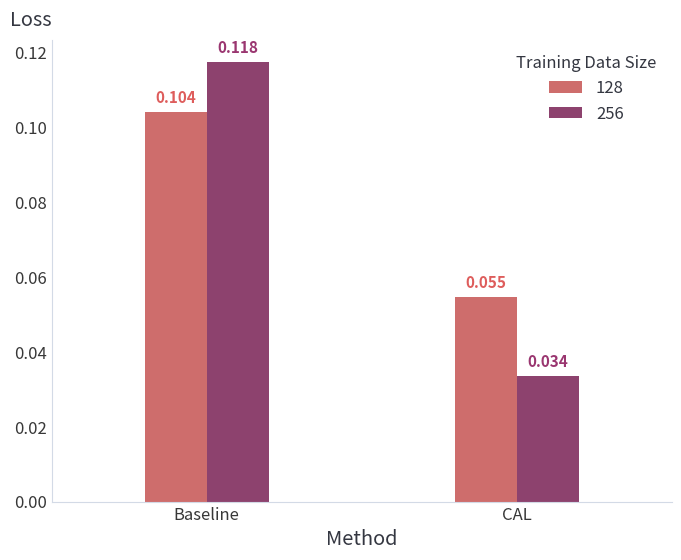

In [110]:
fig, ax = plt.subplots()
piezo = df[df['type'].str.contains('Piezo') & ~df['type'].str.contains('old')] 
piezo_fig = piezo[piezo['dataset'] == "Piezoelectric\n(Relation Shift)"].query('dataset_size > 1 and ema')
piezo_fig['Training Data Size'] = piezo_fig['dataset_size'].map(lambda x: f'{x:.0f}')
piezo_fig = pd.concat([piezo_fig, pd.DataFrame({'type': ['Piezo2'], 'epoch': ['EMA'], 'dataset': ['Piezoelectric\n(Relation Shift)'], 'loss': [0.0548], 
                                                'sal': [True], 'last': [False], 'ema': [True], 'fig': [True], 'dataset_size': [128], 'CAL': ['CAL'], 
                                                'target': [''], 'post': [False], 'Training Data Size': ['128']}, index=[9999])])
sns.barplot(piezo_fig, hue='Training Data Size', x='CAL', y='loss', legend=True, ax=ax, width=0.4, palette='flare')
# ax.set_xticks(ax.get_xticks(), labels=['128', '256'])
# ax.set_xticks(ax.get_xticks(), labels=['Baseline', 'CAL'])
# ax.set_title('Piezoelectric Fine-tuning Performance')

colors = sns.color_palette('flare', 2)
x_offset = 0.1         

ymin, ymax = ax.get_ylim()
y_offset = 0.02 * (ymax - ymin)
for ds_i, ds in enumerate(pd.unique(piezo_fig['CAL'])):
    for method_i, method in enumerate((128, 256)):
        rect: Rectangle = ax.patches[2 * ds_i + method_i]
        loss = piezo_fig[(piezo_fig['CAL'] == ds) & (piezo_fig['dataset_size'] == method)]['loss'].iloc[0]             
        ax.text(x=ds_i + x_offset * (2 * method_i - 1), y=loss + y_offset, s=f'{loss:.03f}', ha='center',
                color=colors[method_i], fontweight='bold', fontsize=11)  
ax.set_xlabel('Method')
ax.set_ylabel('Loss')
rp.ylabel_top()
fig.legend
fig.savefig('figs/piezo.png')

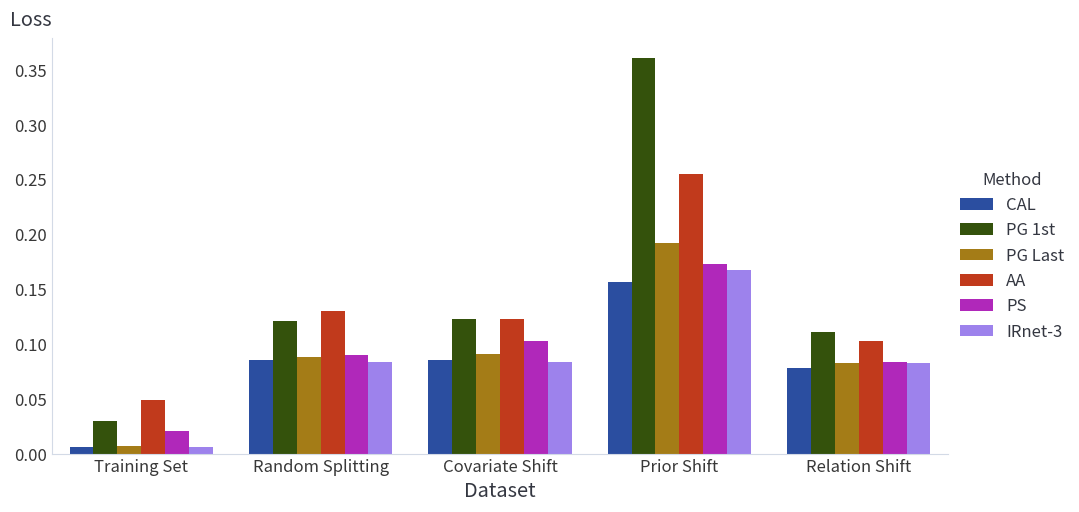

In [ ]:
abl_df = pd.DataFrame({
         'Method': ['CAL', 'PG 1st', 'PG Last', 'AA', 'PS', 'IRnet-3'],
'Training Set':     [0.0061, 0.0296, 0.0071, 0.0487, 0.0204, 0.0059],
'Random Splitting': [0.0851, 0.1206, 0.0880, 0.1299, 0.0903, 0.0837],
'Covariate Shift':  [0.0856, 0.1230, 0.0907, 0.1226, 0.1030, 0.0832],
'Prior Shift':      [0.1564, 0.3609, 0.1919, 0.2548, 0.1729, 0.1676],
'Relation Shift':   [0.0781, 0.1111, 0.0826, 0.1027, 0.0839, 0.0822]})

abl_df = abl_df.melt(id_vars=['Method'], var_name='Dataset', value_name='Loss')

sns.catplot(abl_df, x='Dataset', y='Loss', hue='Method', kind='bar', aspect=2)
rp.ylabel_top()
plt.savefig('figs/ablation.png')

In [ ]:
pdf = pd.read_feather('exps/delta_e_piezo_2/SAL-training_loss.feather')
pdf

,epoch,Train,Partial_train,Rsplt1,Rsplt2,Rsplt3,Rsplt4,Rsplt5,Xshift_tsne,Xshift_umap,statY_delta_e,infoY_delta_e,statY_bandgap,infoY_bandgap,piezo,rsplt_ave,Partial
0,1,0.034715,0.164271,0.102765,0.102031,0.106452,0.108030,0.106872,0.092764,0.123653,0.691778,0.140333,0.156589,0.113302,0.076228,0.105230,NaN
1,2,0.028391,0.050317,0.097718,0.097023,0.101424,0.103113,0.101577,0.088762,0.118496,0.687930,0.135183,0.146572,0.104617,0.069712,0.100171,NaN
2,3,0.026510,0.038649,0.095945,0.095165,0.099448,0.101209,0.099720,0.086470,0.115253,0.684378,0.135769,0.147040,0.104634,0.066970,0.098297,NaN
3,4,0.025408,0.034084,0.094484,0.093560,0.097961,0.099736,0.098228,0.083687,0.112614,0.681039,0.129008,0.138776,0.098714,0.063788,0.096794,NaN
4,5,0.058007,0.194969,0.140352,0.137347,0.145336,0.145452,0.144588,0.166109,0.167949,0.685957,0.264363,0.447714,0.317613,0.039905,0.142615,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,215,0.031007,0.052083,0.109190,0.106569,0.112818,0.114197,0.114178,0.115088,0.136282,0.675602,0.219320,0.305395,0.216091,0.036289,0.111390,NaN
215,216,0.039033,0.048609,0.113077,0.111300,0.117011,0.117136,0.118751,0.122645,0.141093,0.637092,0.235291,0.325209,0.232565,0.037022,0.115455,NaN
216,217,0.025309,0.143991,0.105122,0.103003,0.108424,0.110145,0.109189,0.099944,0.123529,0.702161,0.184028,0.213299,0.157823,0.033452,0.107177,NaN
217,218,0.045642,0.063121,0.130908,0.128928,0.133781,0.137211,0.135112,0.121632,0.170137,0.791748,0.154929,0.150374,0.118313,0.033975,0.133188,NaN


In [ ]:
piezo_tab = df[df['type'].str.contains('iezo') | df['type'].str.contains('ase')].query('ema')
piezo_tab.pivot_table(index='dataset', columns=['type', 'dataset_size'], values='loss').round(4)

type                            Finetune Piezo           Piezo  Piezo2  \
dataset_size                             128.0   256.0   1.0     128.0   
dataset                                                                  
Covariate Shift                         0.0893  0.0900  0.1185  0.1111   
High-Bandgap\nMaterials                 0.0611  0.0507  0.2152  0.2280   
Low ΔE\n(Prior Shift)                   0.0565  0.0442  0.1881  0.2124   
Piezoelectric\n(Relation Shift)         0.1042  0.1176  0.0573  0.0542   
Rsplt1                                  0.0810  0.0811  0.0999  0.0999   
Rsplt2                                  0.0802  0.0804  0.0991  0.0986   
Rsplt3                                  0.0853  0.0855  0.1035  0.1037   
Rsplt4                                  0.0863  0.0865  0.1044  0.1043   
Rsplt5                                  0.0838  0.0839  0.1041  0.1043   
Training                                0.0725  0.0815  0.0249  0.0236   
Validation                              0.0833     NaN  0.1022  0.1021   
Xshift_tsne                             0.0628  0.0627  0.0939  0.0915   
infoY_bandgap                           0.0467  0.0396  0.1496  0.1634   
statY_delta_e                           0.5921  0.5797  0.6976  0.6858   

type                                    baseline  
dataset_size                      256.0    1.0    
dataset                                           
Covariate Shift                  0.1143   0.0850  
High-Bandgap\nMaterials          0.1688   0.1359  
Low ΔE\n(Prior Shift)            0.1680   0.1512  
Piezoelectric\n(Relation Shift)  0.0365   0.0794  
Rsplt1                           0.0963   0.0810  
Rsplt2                           0.0950   0.0802  
Rsplt3                           0.1000   0.0852  
Rsplt4                           0.1012   0.0857  
Rsplt5                           0.1003   0.0843  
Training                         0.0186   0.0042  
Validation                       0.0985   0.0832  
Xshift_tsne                      0.0905   0.0602  
infoY_bandgap                    0.1241   0.1001  
statY_delta_e                    0.7043   0.6729

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


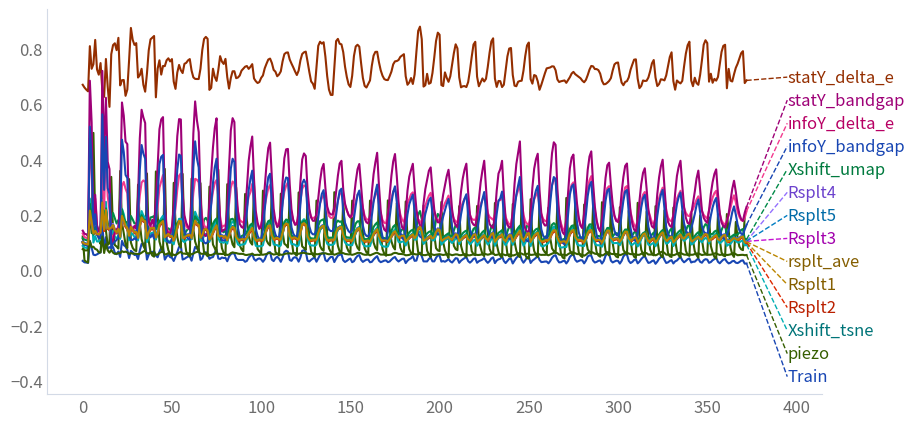

In [ ]:
pdf = pd.read_feather('exps/delta_e_piezo_3_long/SAL-training_loss.feather')
pdf.sort_values('epoch')

fig, ax = plt.subplots(figsize=(10, 5))
pdf.drop(columns=['epoch']).plot(ax=ax)
rp.line_labels()

dataset,Rsplt1,Rsplt2,Rsplt3,Rsplt4,Rsplt5,Xshift_tsne,Xshift_umap,infoY_bandgap,infoY_delta_e,piezo,statY_bandgap,statY_delta_e
output,-1.412722,-1.418012,-1.409161,-1.388913,-1.399050,-1.575561,-1.090978,-2.056470,-2.716198,-1.633095,-2.029848,-1.500480
target,-1.480051,-1.485498,-1.470971,-1.445060,-1.466887,-1.691499,-1.120132,-2.518289,-3.298072,-1.726399,-2.602811,-1.127669
loss,0.099852,0.098586,0.103670,0.104276,0.104255,0.091496,0.111088,0.163360,0.212435,0.054227,0.227955,0.685746


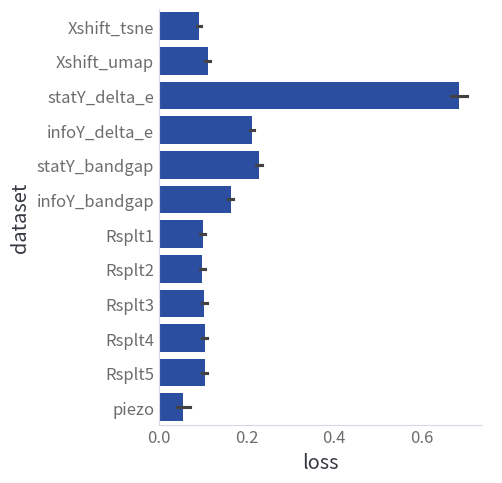

In [ ]:
resdf = pd.read_feather('exps/delta_e_piezo_3_long/results_ema.feather')
display(resdf.groupby('dataset').mean().T)
sns.catplot(resdf, y='dataset', x='loss', kind='bar')

dataset,Rsplt1,Rsplt2,Rsplt3,Rsplt4,Rsplt5,Xshift_tsne,Xshift_umap,infoY_bandgap,infoY_delta_e,piezo,statY_bandgap,statY_delta_e
output,-1.425150,-1.429386,-1.421442,-1.401112,-1.411394,-1.597395,-1.115205,-2.062335,-2.724597,-1.640258,-2.038497,-1.500387
target,-1.480051,-1.485498,-1.470971,-1.445060,-1.466887,-1.691499,-1.120132,-2.518289,-3.298072,-1.726399,-2.602811,-1.127669
loss,0.097760,0.096720,0.101364,0.102384,0.102030,0.088498,0.108591,0.161201,0.210865,0.054653,0.224037,0.688352


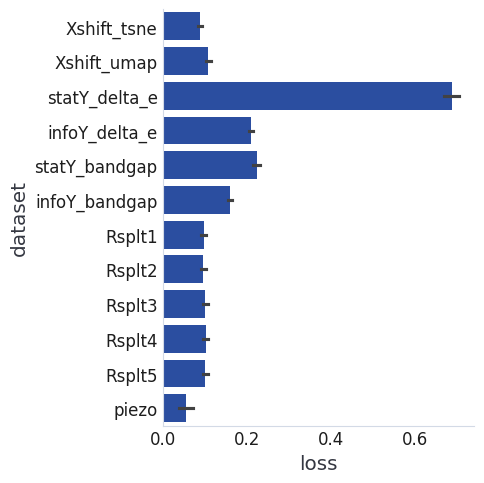

In [ ]:
resdf = pd.read_feather('exps/delta_e_piezo_3_weighted/results_ema.feather')
display(resdf.groupby('dataset').mean().T)
sns.catplot(resdf, y='dataset', x='loss', kind='bar')

In [ ]:
resdf.query('dataset == "piezo"').shape

(126, 4)

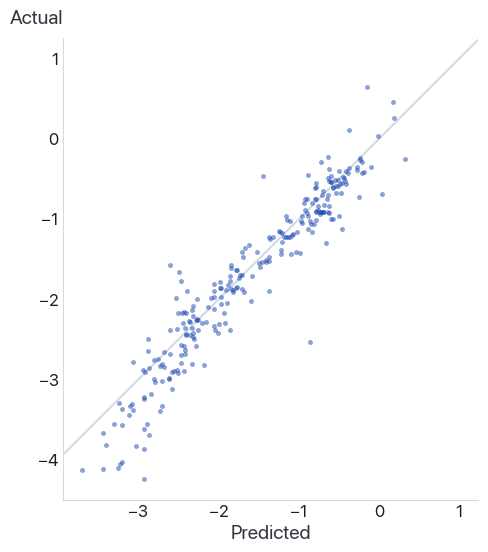

In [ ]:
plt.gca().set_aspect('equal', adjustable='box')
plt.axline((0, 0), (1, 1), c=plt.rcParams['axes.edgecolor'], zorder=-99)
sns.scatterplot(resdf.query('dataset == "piezo"'), x='output', y='target', ec=None, s=10, alpha=0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
# plt.title('Predicted Formation Energy (Piezo)')
rp.ylabel_top()
plt.savefig('figs/piezo_scatter.png')

/tmp/ipykernel_478189/3640890726.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subs['CAL'] = np.where(subs['sal'], 'CAL', 'Baseline')


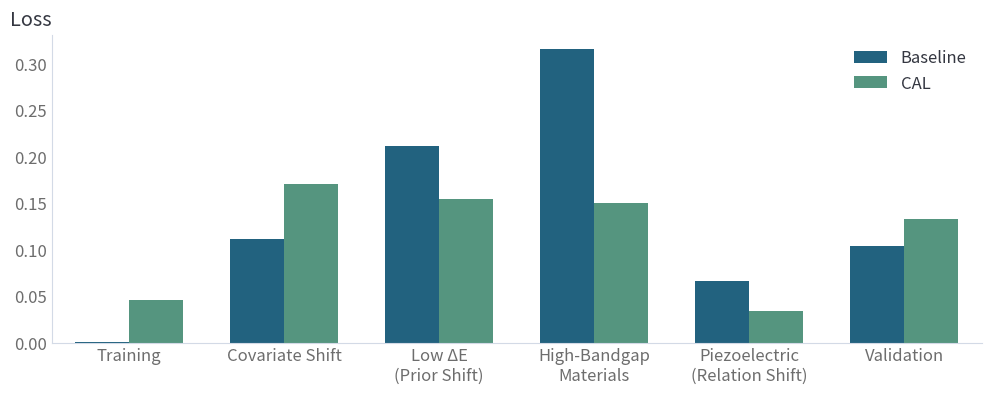

In [ ]:
fig, ax = normal_plot(piezo.query('fig and last and ((not sal and dataset_size == 128) or (sal and dataset_size == 256))'))
# ax.set_title('Piezoelectric Fine-Tuning')
fig.savefig('figs/normal_piezo.png')

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


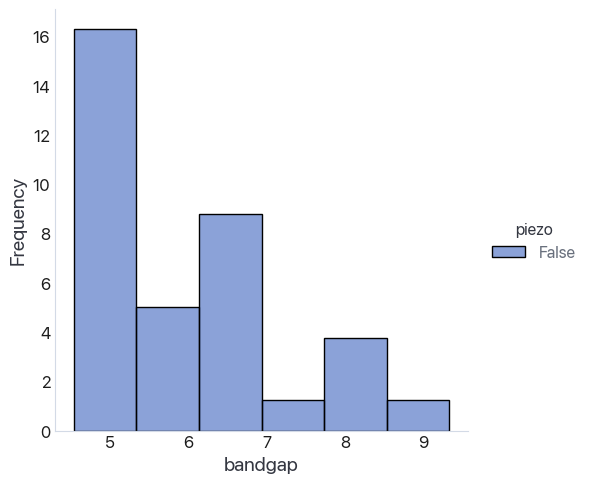

In [ ]:
sns.displot(data.query('dataset_split == 7 and statY_bandgap'), x='bandgap', hue='piezo', stat='frequency')

In [ ]:
from pathlib import Path

results = {}
for feather in Path('exps/results').glob('*.feather'):
    results[feather.name] = pd.read_feather(feather)

{k: len(v.index) for k, v in results.items()}

{'delta_e_03-04-14-14.feather': 126,
 'delta_e_Yinfo_256x2.feather': 143,
 'delta_e_piezo_128_early_stop.feather': 61,
 'delta_e_statY.feather': 454,
 'delta_e_Yinfo_256x16.feather': 328,
 'delta_e_Xumap.feather': 381,
 'delta_e_Xtsne.feather': 175,
 'delta_e_baseline.feather': 103,
 'delta_e_Yinfo_256x1.feather': 358,
 'delta_e_Yinfo_256x8_no_space.feather': 245,
 'delta_e_Xumap_256x4.feather': 501,
 'delta_e_piezo_128.feather': 223,
 'delta_e_Yinfo_256x4.feather': 133,
 'delta_e_Yinfo_256x32.feather': 138,
 'delta_e_Yinfo_256x8.feather': 420,
 'delta_e_Xtsne_256x4.feather': 265}

In [ ]:
!ls exps/

delta_e_02-04-15-04/             delta_e_02-26-21-19/
delta_e_02-04-long/              delta_e_02-26-21-31/
delta_e_02-05-13-23/             delta_e_02-26-21-43/
delta_e_02-05-13-25/             delta_e_02-26-22-21/
delta_e_02-05-better-hopefully/  delta_e_02-26-23-03/
delta_e_02-12-13-31/             delta_e_02-27-10-31/
delta_e_02-12-13-42/             delta_e_02-27-11-29/
delta_e_02-12-13-45/             delta_e_02-27-12-11/
delta_e_02-12-13-46/             delta_e_02-27-16-46/
delta_e_02-12-13-50/             delta_e_02-27-18-16/
delta_e_02-12-13-51/             delta_e_04-22-10-51/
delta_e_02-19-13-22/             delta_e_04-22-11-28/
delta_e_02-19-13-30/             delta_e_04-22-11-29/
delta_e_02-19-13-31/             delta_e_04-22-11-30/
delta_e_02-19-13-33/             delta_e_04-22-11-31/
delta_e_02-19-13-35/             delta_e_04-22-11-32/
delta_e_02-19-13-42/             delta_e_04-22-11-44/
delta_e_02-19-13-46/             delta_e_04-22-12-41/
delta_e_02-19-13-47/        

/home/nicholas/anaconda3/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
infoy = pd.read_feather('exps/results/delta_e_Yinfo_256x1.feather')
infoy.sort_values('Partial_train').head(30)

,epoch,Train,Partial_train,Rsplt1,Rsplt2,Rsplt3,Rsplt4,Rsplt5,Xshift_tsne,Xshift_umap,statY_delta_e,infoY_delta_e,statY_bandgap,infoY_bandgap,piezo,rsplt_ave,Partial
9,10,0.019338,0.028355,0.089003,0.088098,0.092461,0.093719,0.092862,0.077333,0.102939,0.668191,0.147015,0.157235,0.110054,0.079661,0.091229,NaN
8,9,0.019559,0.029924,0.089048,0.088229,0.092531,0.093775,0.092964,0.076226,0.102460,0.668196,0.142671,0.151888,0.106893,0.079590,0.091310,NaN
6,7,0.020893,0.030370,0.088808,0.087993,0.092328,0.093600,0.092536,0.075736,0.102512,0.659472,0.135045,0.146449,0.103476,0.079293,0.091053,NaN
5,6,0.021386,0.031966,0.090729,0.089819,0.094269,0.095504,0.094426,0.079729,0.106331,0.666584,0.144477,0.158723,0.112111,0.081085,0.092949,NaN
7,8,0.020615,0.032179,0.089756,0.088755,0.093153,0.094428,0.093606,0.077679,0.104107,0.667467,0.141639,0.153282,0.107309,0.081211,0.091940,NaN
3,4,0.023509,0.032999,0.092877,0.091906,0.096152,0.097707,0.096608,0.082096,0.110581,0.672042,0.144292,0.159091,0.112420,0.081929,0.095050,NaN
4,5,0.022401,0.033463,0.091077,0.090279,0.094651,0.095972,0.094789,0.078424,0.106094,0.665299,0.140354,0.154651,0.109623,0.082663,0.093354,NaN
2,3,0.024914,0.036673,0.095132,0.094308,0.098405,0.100017,0.098910,0.084381,0.112927,0.681693,0.149679,0.160538,0.114636,0.084525,0.097354,NaN
63,64,0.083351,0.045463,0.148067,0.147690,0.152733,0.155860,0.151612,0.123420,0.180097,0.764543,0.029809,0.056272,0.048497,0.123731,0.151192,NaN
1,2,0.026953,0.049022,0.097327,0.096447,0.100698,0.102158,0.101192,0.088895,0.117874,0.683448,0.157137,0.173193,0.122552,0.086763,0.099565,NaN


In [ ]:
infoy = pd.read_feather('exps/results/delta_e_Yinfo_256x1.feather')
infoy.sort_values('Partial_train').head(30)

,epoch,Train,Partial_train,Rsplt1,Rsplt2,Rsplt3,Rsplt4,Rsplt5,Xshift_tsne,Xshift_umap,statY_delta_e,infoY_delta_e,statY_bandgap,infoY_bandgap,piezo,rsplt_ave,Partial
9,10,0.019338,0.028355,0.089003,0.088098,0.092461,0.093719,0.092862,0.077333,0.102939,0.668191,0.147015,0.157235,0.110054,0.079661,0.091229,NaN
8,9,0.019559,0.029924,0.089048,0.088229,0.092531,0.093775,0.092964,0.076226,0.102460,0.668196,0.142671,0.151888,0.106893,0.079590,0.091310,NaN
6,7,0.020893,0.030370,0.088808,0.087993,0.092328,0.093600,0.092536,0.075736,0.102512,0.659472,0.135045,0.146449,0.103476,0.079293,0.091053,NaN
5,6,0.021386,0.031966,0.090729,0.089819,0.094269,0.095504,0.094426,0.079729,0.106331,0.666584,0.144477,0.158723,0.112111,0.081085,0.092949,NaN
7,8,0.020615,0.032179,0.089756,0.088755,0.093153,0.094428,0.093606,0.077679,0.104107,0.667467,0.141639,0.153282,0.107309,0.081211,0.091940,NaN
3,4,0.023509,0.032999,0.092877,0.091906,0.096152,0.097707,0.096608,0.082096,0.110581,0.672042,0.144292,0.159091,0.112420,0.081929,0.095050,NaN
4,5,0.022401,0.033463,0.091077,0.090279,0.094651,0.095972,0.094789,0.078424,0.106094,0.665299,0.140354,0.154651,0.109623,0.082663,0.093354,NaN
2,3,0.024914,0.036673,0.095132,0.094308,0.098405,0.100017,0.098910,0.084381,0.112927,0.681693,0.149679,0.160538,0.114636,0.084525,0.097354,NaN
63,64,0.083351,0.045463,0.148067,0.147690,0.152733,0.155860,0.151612,0.123420,0.180097,0.764543,0.029809,0.056272,0.048497,0.123731,0.151192,NaN
1,2,0.026953,0.049022,0.097327,0.096447,0.100698,0.102158,0.101192,0.088895,0.117874,0.683448,0.157137,0.173193,0.122552,0.086763,0.099565,NaN


In [ ]:
infoy = pd.read_feather('exps/results/delta_e_Yinfo_256x4.feather')
# infoy.sort_values('infoY_delta_e')
infoy.sort_values('infoY_delta_e')

,epoch,Train,Partial_train,Rsplt1,Rsplt2,Rsplt3,Rsplt4,Rsplt5,Xshift_tsne,Xshift_umap,statY_delta_e,infoY_delta_e,statY_bandgap,infoY_bandgap,piezo,rsplt_ave,Partial
130,131,0.066547,0.291107,0.122730,0.122328,0.126922,0.128265,0.126783,0.103166,0.160659,0.635234,0.009238,0.038341,0.035387,0.116303,0.125406,NaN
122,123,0.169280,0.165610,0.166083,0.167275,0.168559,0.169025,0.171080,0.107934,0.169192,0.342136,0.009707,0.059803,0.058084,0.166390,0.168405,NaN
124,125,0.183485,0.372238,0.238322,0.238215,0.243165,0.246120,0.243368,0.181285,0.302468,0.893450,0.009868,0.037637,0.035312,0.200515,0.241838,NaN
118,119,0.057609,0.229279,0.103580,0.104149,0.108462,0.108969,0.107785,0.083132,0.125254,0.538548,0.010148,0.035635,0.035590,0.115702,0.106589,NaN
128,129,0.125574,0.157051,0.137030,0.139592,0.140680,0.141968,0.142679,0.091895,0.150541,0.380342,0.010227,0.047446,0.044243,0.138467,0.140390,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,10,0.019338,0.028355,0.089003,0.088098,0.092461,0.093719,0.092862,0.077333,0.102939,0.668191,0.147543,0.157235,0.110054,0.079661,0.091229,NaN
2,3,0.024914,0.036673,0.095132,0.094308,0.098405,0.100017,0.098910,0.084381,0.112927,0.681693,0.150096,0.160538,0.114636,0.084525,0.097354,NaN
0,1,0.033386,0.163024,0.102248,0.101634,0.105700,0.107317,0.106440,0.093665,0.123803,0.688389,0.157388,0.174223,0.124866,0.090929,0.104668,NaN
1,2,0.026953,0.049022,0.097327,0.096447,0.100698,0.102158,0.101192,0.088895,0.117874,0.683448,0.157738,0.173193,0.122552,0.086763,0.099565,NaN


In [ ]:
staty = df[df['type'].str.contains('statY', case=False)]
staty

,type,epoch,dataset,loss,sal,last,ema,fig,dataset_size,CAL,target,post
59,StatY,451,Training,0.0993,True,False,False,True,256.0,CAL,,False
60,StatY,452,Training,0.0596,True,False,False,True,256.0,CAL,,False
61,StatY,last,Training,0.0757,True,True,False,True,256.0,CAL,,False
62,StatY,EMA,Training,0.0740,True,False,True,True,256.0,CAL,,False
63,statY,224,Training,0.1475,True,False,False,True,1024.0,CAL,,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1357,Finetune statY,last,Validation,0.2707,False,True,False,True,256.0,Baseline,,False
1358,Finetune statY,EMA,Validation,0.0934,False,False,True,True,1024.0,Baseline,,False
1359,Finetune statY,best_vaild,Validation,0.2904,False,False,False,True,1024.0,Baseline,,False
1360,Finetune statY,IR3_best_train,Validation,0.2781,False,False,False,True,1024.0,Baseline,,False


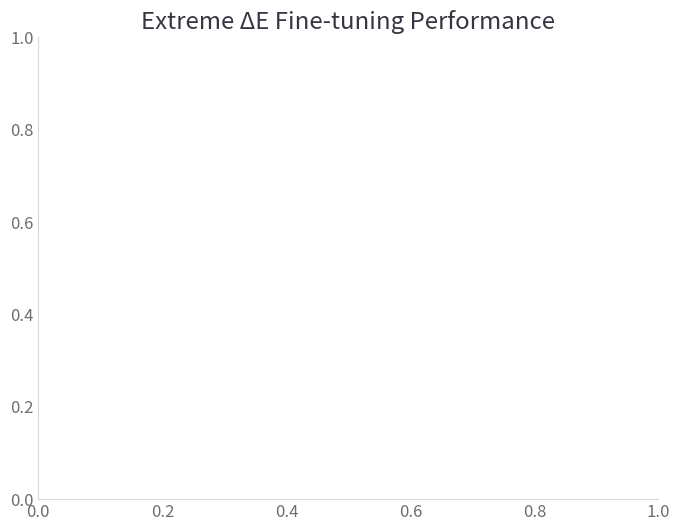

In [ ]:
fig, ax = plt.subplots()
sns.barplot(staty.query('dataset == "Extreme ΔE" and last'), hue='sal', x='dataset_size', y='loss', legend=True, ax=ax)
ax.set_title('Extreme ΔE Fine-tuning Performance')
fig.savefig('figs/staty.png')

In [ ]:
fig, ax = normal_plot(staty.query('fig and last and dataset_size != 256'))
# ax.set_title('Extreme ΔE Fine-Tuning')
fig.savefig('figs/normal_staty.png')

NameError: name 'staty' is not defined

In [ ]:

from pathlib import Path

from tomllib import load

res = []

for fn in Path('exps/results').glob('*.feather'):
    if 'early_stop' in fn.name:
        continue
    toml_fn = fn.with_suffix('.toml')
    with open(toml_fn, 'rb') as toml_f:
        toml = load(toml_f)
        res_df = pd.read_feather(fn)
        res_df['exp_id'] = fn.stem
        res_df['exp'] = toml['log']['exp_name']
        res_df['adv_data'] = toml.get('adv_train_data', 'Baseline')
        res_df['batch_size'] = toml['data']['batch_size']
        res_df['batch_num'] = toml['data']['num_sal_samples'] // res_df['batch_size']
        res_df['total_size'] = toml['data']['num_sal_samples']
        res_df['target'] = toml['target']['col_name']
        res_df['ema'] = pd.isna(res_df['Partial_train'])
        res.append(res_df)


res = pd.concat(res)

In [ ]:
res

,epoch,Train,Partial_train,Rsplt1,Rsplt2,Rsplt3,Rsplt4,Rsplt5,Xshift_tsne,Xshift_umap,...,rsplt_ave,Partial,exp_id,exp,adv_data,batch_size,batch_num,total_size,target,ema
0,1,0.033593,0.169762,0.106492,0.105785,0.109878,0.111315,0.110673,0.098757,0.128702,...,0.108829,NaN,delta_e_03-04-14-14,baseline,Baseline,256,4,1024,delta_e,False
1,2,0.027029,0.048250,0.097932,0.097250,0.101474,0.102999,0.102103,0.088735,0.118175,...,0.100352,NaN,delta_e_03-04-14-14,baseline,Baseline,256,4,1024,delta_e,False
2,3,0.024405,0.037683,0.095890,0.095147,0.099427,0.100892,0.099912,0.087223,0.115273,...,0.098253,NaN,delta_e_03-04-14-14,baseline,Baseline,256,4,1024,delta_e,False
3,4,0.022895,0.032993,0.094287,0.093459,0.097655,0.099223,0.098149,0.084806,0.113807,...,0.096555,NaN,delta_e_03-04-14-14,baseline,Baseline,256,4,1024,delta_e,False
4,5,0.021416,0.033871,0.092455,0.091594,0.095807,0.097314,0.096251,0.080575,0.108735,...,0.094684,NaN,delta_e_03-04-14-14,baseline,Baseline,256,4,1024,delta_e,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,261,0.022528,0.080532,0.085958,0.085859,0.089569,0.089701,0.089591,0.043791,0.075409,...,0.088136,NaN,delta_e_Xtsne_256x4,Xtsne_256x4,Xshift_tsne,256,4,1024,delta_e,False
261,262,0.022179,0.079354,0.084630,0.083896,0.088061,0.088639,0.087841,0.042670,0.073951,...,0.086613,NaN,delta_e_Xtsne_256x4,Xtsne_256x4,Xshift_tsne,256,4,1024,delta_e,False
262,263,0.021822,0.093903,0.089771,0.088124,0.092793,0.093498,0.092357,0.045286,0.078905,...,0.091309,NaN,delta_e_Xtsne_256x4,Xtsne_256x4,Xshift_tsne,256,4,1024,delta_e,False
263,264,0.020975,0.087553,0.085934,0.084657,0.089305,0.089756,0.088966,0.044209,0.078081,...,0.087724,NaN,delta_e_Xtsne_256x4,Xtsne_256x4,Xshift_tsne,256,4,1024,delta_e,False


(0.0, 0.2)

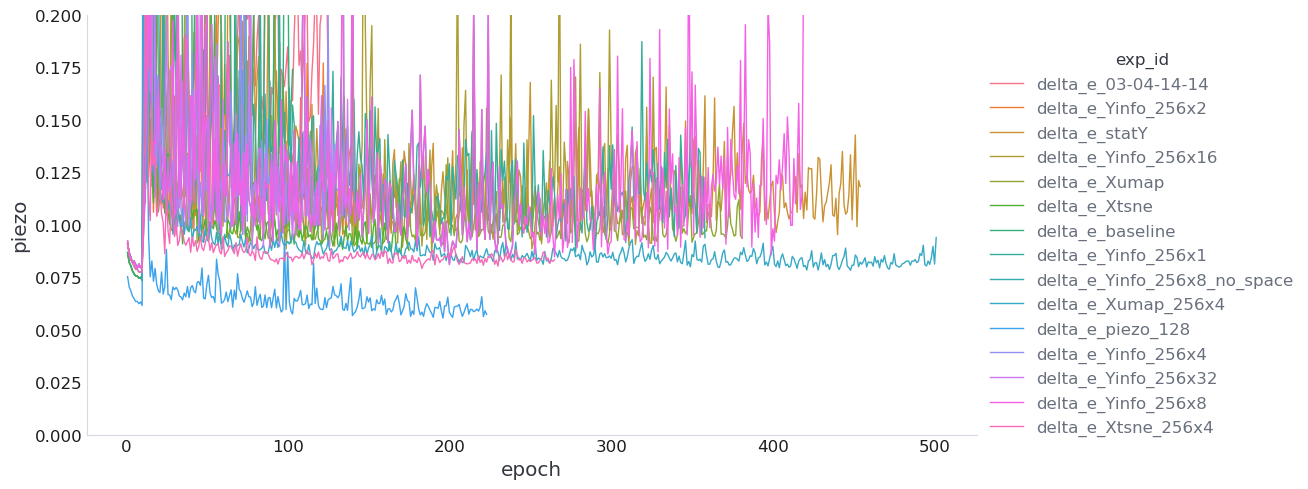

In [ ]:
sns.relplot(res, x='epoch', y='piezo', hue='exp_id', kind='line', aspect=2, height=5, lw=1)
plt.ylim(0, 0.2)

In [ ]:
res.query('not ema').sort_values('infoY_delta_e', ascending=True).groupby('exp_id').first()[['infoY_delta_e', 'epoch', 'adv_data']]

,infoY_delta_e,epoch,adv_data
exp_id,,,
delta_e_03-04-14-14,0.044386,12,Baseline
delta_e_Xtsne,0.041182,12,Xshift_tsne
delta_e_Xtsne_256x4,0.038342,21,Xshift_tsne
delta_e_Xumap,0.037713,15,Xshift_umap
delta_e_Xumap_256x4,0.032853,31,Xshift_umap
delta_e_Yinfo_256x1,0.018155,341,infoY_delta_e
delta_e_Yinfo_256x16,0.009092,306,infoY_delta_e
delta_e_Yinfo_256x2,0.013415,141,infoY_delta_e
delta_e_Yinfo_256x32,0.006963,137,infoY_delta_e


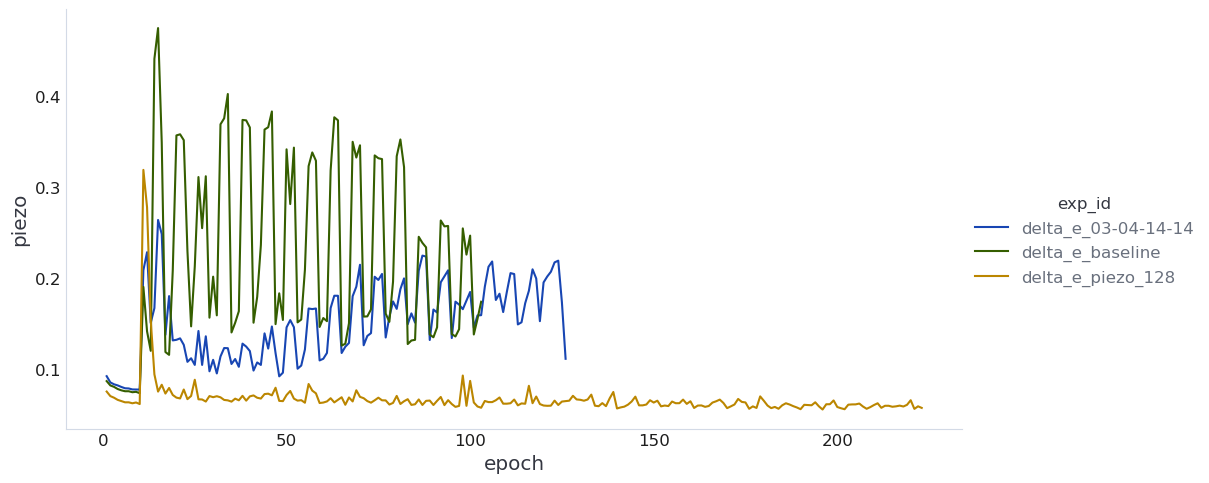

In [ ]:
sns.relplot(res.query('adv_data == "piezo" or adv_data == "Baseline"'), x='epoch', y='piezo', hue='exp_id', kind='line', aspect=2, height=5)

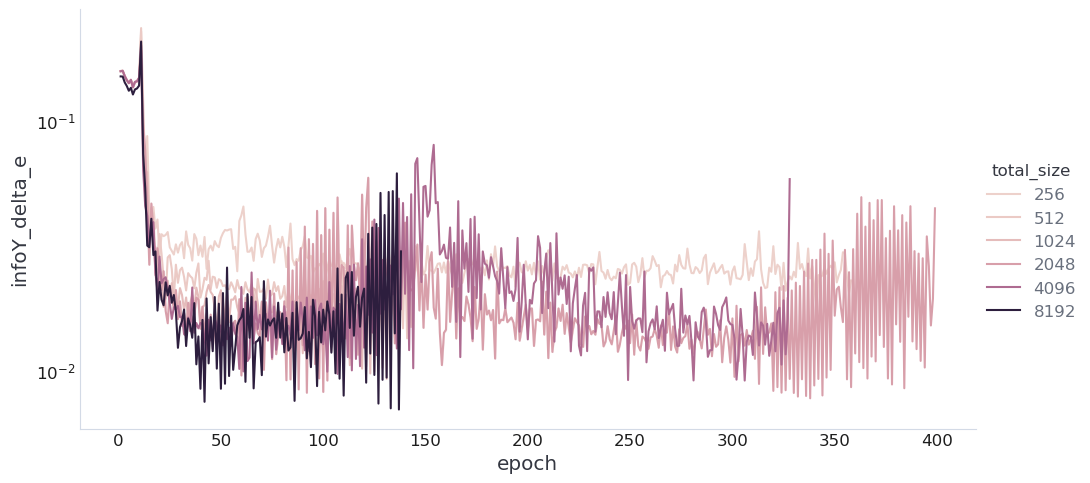

In [ ]:
infoy = res.query('adv_data == "infoY_delta_e" and epoch < 400')
sns.relplot(infoy, x='epoch', y='infoY_delta_e', hue='total_size', kind='line', aspect=2, height=5)
plt.yscale('log')

Change high-bandgap: make clear it's a dataset

Change gradient section

Change validation

bandgap plot

distribution loss

compare both models
